# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0 -0.465928 -0.266161  0.0  0.434047  0.523534 -1.025592  2  2  20.291856   
1 -0.947866  0.558591  0.0  0.174837 -0.665951  0.027926  1  2  14.269448   
2  0.828876  1.528020  0.0  0.260002  0.242554 -1.997563  3  2  19.949817   
3  1.059840  0.612905  0.0  0.518193  0.025459 -0.239411  1  1  15.123049   
4 -0.126465  0.933031  0.0  0.128444  1.885027 -0.581068  1  2  15.209074   

            y  
0  178.491605  
1  170.315030  
2  344.284475  
3  205.899933  
4  220.129659  
True causal estimate is 10.35774893723197


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

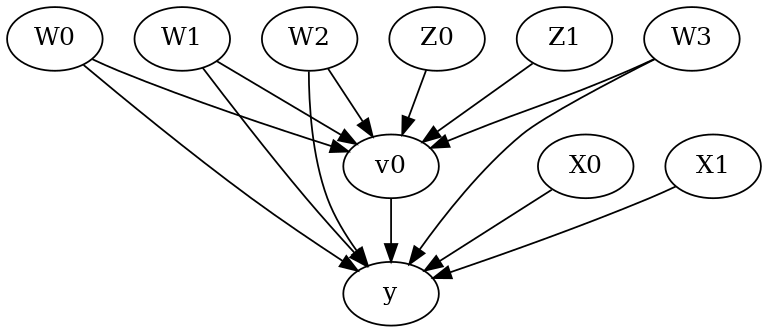

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 10.357728348482452
### Conditional Estimates
__categorical__X1  __categorical__X0            
(-3.709, -0.692]   (-4.7540000000000004, -1.177]     3.499329
                   (-1.177, -0.586]                  4.014806
                   (-0.586, -0.0695]                 4.433981
                   (-0.0695, 0.506]                  4.913607
                   (0.506, 3.513]                    5.444423
(-0.692, -0.11]    (-4.7540000000000004, -1.177]     7.049114
                   (-1.177, -0.586]                  7.695844
                   (-0.586, -0.0695]               

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

2022-08-22 05:38:32.164589: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 05:38:32.164633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 11.62467281842602
Effect estimates: [13.41071906 11.72434117  5.55066538 16.32605935 14.58341195 10.23831675
  5.2438804  13.75227526  7.27413971  5.90279282 17.24515314  7.65470178
 19.08901413 13.42411532  4.46129838  8.002626   19.13783007 15.36304052
 12.32395873 16.30170948 14.49206201 11.04361672 12.75250177  8.83048266
  7.72253242 13.41162502  7.83128073  9.55261241  9.20607559 16.98931915
  9.83555151 11.54472618 11.61111485  9.06208733  9.61768281 17.02378043
 10.13848423 20.15682868 14.36522012 18.2960324  15.00386727 10.08561315
 18.48

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 10.35774893723197


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: 

## Estimate
Mean value: 10.335911129216896
Effect estimates: [ 8.46123694 11.65735908 17.21976605 ...  3.27565856 13.92728916
 11.81566338]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 10.30674308543071
Effect estimates: [ 8.44923094 11.64252384 17.10247782 ...  3.27513924 13.80785766
 11.73592573]
95.0% confidence interval: (array([ 8.4768338 , 11.68300901, 17.065888  , ...,  3.05066685,
       13.757685  , 11.7400844 ]), array([ 8.6263527 , 11.92741978, 17.55841973, ...,  3.46572385,
       14.1349238 , 11.97418093]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.12768494 11.13653891 11.79563038 11.37981604 13.52973901 13.67770016
 10.79500474 12.64844545 13.4808509  12.3378925 ]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -1.152528  0.572415  1.0  0.704589 -0.712714 -1.241704  0.155034   
1     0.053820 -1.483272  1.0  0.054824 -1.114304  0.796734  1.424171   
2    -0.418334 -0.508786  1.0  0.093224 -1.079868  1.113802  0.901613   
3    -1.000435  0.086588  1.0  0.602176 -2.584451 -1.359419  1.141118   
4     0.390133  1.034308  1.0  0.869272  0.358883  1.658142  1.982332   
...        ...       ...  ...       ...       ...       ...       ...   
9995  0.482326 -1.123754  1.0  0.429749  0.084026 -0.270240  1.461307   
9996  0.637705 -0.334882  1.0  0.776109  0.512950 -0.188000  3.407485   
9997 -0.336753  1.397986  0.0  0.622429 -1.237140 -0.659284  3.544421   
9998 -0.031248 -1.447385  1.0  0.695569 -0.468887 -1.231240  0.769473   
9999 -2.553756 -1.017517  1.0  0.940134  0.468385 -1.914177  0.060153   

            W3  v0  y  
0     0.390230   1  1  
1     0.143369   1  1  
2     0.660086   1  1  
3    -0.675010   1  0  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W2,W0,W3,W1])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W3,W1,U) = P(y|v0,W2,W0,W3,W1)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: ate

## Estimate
Mean value: 0.4231891022620162
Effect estimates: [0.57222516 0.36778716 0.4668844  ... 0.68281798 0.36995357 0.36296049]

True causal estimate is 0.3066


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-22 05:42:04.290713: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-22 05:42:04.294661: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-22 05:42:04.294688: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (31bef94e9c83): /proc/driver/nvidia/version does not exist
2022-08-22 05:42:04.295005: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:05 - loss: 200.8083

 25/313 [=>............................] - ETA: 0s - loss: 89.7348   

 44/313 [===>..........................] - ETA: 0s - loss: 57.6018

 69/313 [=====>........................] - ETA: 0s - loss: 38.8904

 94/313 [========>.....................] - ETA: 0s - loss: 29.8550

119/313 [==========>...................] - ETA: 0s - loss: 24.5521

145/313 [============>.................] - ETA: 0s - loss: 20.9367

171/313 [===============>..............] - ETA: 0s - loss: 18.4109

195/313 [=================>............] - ETA: 0s - loss: 16.6652

220/313 [====================>.........] - ETA: 0s - loss: 15.2598

246/313 [======================>.......] - ETA: 0s - loss: 14.0849

272/313 [=========================>....] - ETA: 0s - loss: 13.1212

297/313 [===========================>..] - ETA: 0s - loss: 12.3554

313/313 [==============================] - 1s 2ms/step - loss: 11.9291


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.0098

 23/313 [=>............................] - ETA: 0s - loss: 3.9471

 48/313 [===>..........................] - ETA: 0s - loss: 3.9384

 72/313 [=====>........................] - ETA: 0s - loss: 3.9277

 96/313 [========>.....................] - ETA: 0s - loss: 3.9133

120/313 [==========>...................] - ETA: 0s - loss: 3.8988

145/313 [============>.................] - ETA: 0s - loss: 3.8837

170/313 [===============>..............] - ETA: 0s - loss: 3.8690

195/313 [=================>............] - ETA: 0s - loss: 3.8486

217/313 [===================>..........] - ETA: 0s - loss: 3.8396

239/313 [=====================>........] - ETA: 0s - loss: 3.8190

263/313 [========================>.....] - ETA: 0s - loss: 3.8062

289/313 [==========================>...] - ETA: 0s - loss: 3.7953

313/313 [==============================] - 1s 2ms/step - loss: 3.7733


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 3.4693

 27/313 [=>............................] - ETA: 0s - loss: 3.5705

 53/313 [====>.........................] - ETA: 0s - loss: 3.5193

 79/313 [======>.......................] - ETA: 0s - loss: 3.4665

103/313 [========>.....................] - ETA: 0s - loss: 3.4535

128/313 [===========>..................] - ETA: 0s - loss: 3.4320

151/313 [=============>................] - ETA: 0s - loss: 3.4153

172/313 [===============>..............] - ETA: 0s - loss: 3.4029

196/313 [=================>............] - ETA: 0s - loss: 3.3775

221/313 [====================>.........] - ETA: 0s - loss: 3.3655

244/313 [======================>.......] - ETA: 0s - loss: 3.3483

269/313 [========================>.....] - ETA: 0s - loss: 3.3367

294/313 [===========================>..] - ETA: 0s - loss: 3.3225

313/313 [==============================] - 1s 2ms/step - loss: 3.3154


Epoch 4/25


  1/313 [..............................] - ETA: 0s - loss: 2.9289

 27/313 [=>............................] - ETA: 0s - loss: 3.1991

 53/313 [====>.........................] - ETA: 0s - loss: 3.1780

 77/313 [======>.......................] - ETA: 0s - loss: 3.1637

 95/313 [========>.....................] - ETA: 0s - loss: 3.1501

118/313 [==========>...................] - ETA: 0s - loss: 3.1340

144/313 [============>.................] - ETA: 0s - loss: 3.1268

170/313 [===============>..............] - ETA: 0s - loss: 3.1230

194/313 [=================>............] - ETA: 0s - loss: 3.1221

215/313 [===================>..........] - ETA: 0s - loss: 3.1174

238/313 [=====================>........] - ETA: 0s - loss: 3.1181

261/313 [========================>.....] - ETA: 0s - loss: 3.1162

287/313 [==========================>...] - ETA: 0s - loss: 3.1069

313/313 [==============================] - ETA: 0s - loss: 3.1021

313/313 [==============================] - 1s 2ms/step - loss: 3.1021


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 3.3934

 26/313 [=>............................] - ETA: 0s - loss: 3.0893

 50/313 [===>..........................] - ETA: 0s - loss: 3.0562

 76/313 [======>.......................] - ETA: 0s - loss: 3.0366

100/313 [========>.....................] - ETA: 0s - loss: 3.0230

126/313 [===========>..................] - ETA: 0s - loss: 3.0273

152/313 [=============>................] - ETA: 0s - loss: 3.0321

177/313 [===============>..............] - ETA: 0s - loss: 3.0256

201/313 [==================>...........] - ETA: 0s - loss: 3.0258

226/313 [====================>.........] - ETA: 0s - loss: 3.0145

252/313 [=======================>......] - ETA: 0s - loss: 3.0148

277/313 [=========================>....] - ETA: 0s - loss: 3.0090

303/313 [============================>.] - ETA: 0s - loss: 3.0109

313/313 [==============================] - 1s 2ms/step - loss: 3.0093


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 2.8084

 27/313 [=>............................] - ETA: 0s - loss: 2.9526

 52/313 [===>..........................] - ETA: 0s - loss: 2.9612

 77/313 [======>.......................] - ETA: 0s - loss: 2.9775

102/313 [========>.....................] - ETA: 0s - loss: 2.9779

128/313 [===========>..................] - ETA: 0s - loss: 2.9771

154/313 [=============>................] - ETA: 0s - loss: 2.9657

180/313 [================>.............] - ETA: 0s - loss: 2.9690

204/313 [==================>...........] - ETA: 0s - loss: 2.9621

229/313 [====================>.........] - ETA: 0s - loss: 2.9598

254/313 [=======================>......] - ETA: 0s - loss: 2.9554

279/313 [=========================>....] - ETA: 0s - loss: 2.9492

301/313 [===========================>..] - ETA: 0s - loss: 2.9472

313/313 [==============================] - 1s 2ms/step - loss: 2.9440


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.9101

 26/313 [=>............................] - ETA: 0s - loss: 2.8808

 51/313 [===>..........................] - ETA: 0s - loss: 2.9062

 73/313 [=====>........................] - ETA: 0s - loss: 2.9079

 96/313 [========>.....................] - ETA: 0s - loss: 2.9230

120/313 [==========>...................] - ETA: 0s - loss: 2.9147

145/313 [============>.................] - ETA: 0s - loss: 2.9082

170/313 [===============>..............] - ETA: 0s - loss: 2.9123

195/313 [=================>............] - ETA: 0s - loss: 2.9139

219/313 [===================>..........] - ETA: 0s - loss: 2.9116

242/313 [======================>.......] - ETA: 0s - loss: 2.9062

268/313 [========================>.....] - ETA: 0s - loss: 2.9014

293/313 [===========================>..] - ETA: 0s - loss: 2.9018

313/313 [==============================] - 1s 2ms/step - loss: 2.9014


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 2.9933

 27/313 [=>............................] - ETA: 0s - loss: 2.9079

 53/313 [====>.........................] - ETA: 0s - loss: 2.8905

 77/313 [======>.......................] - ETA: 0s - loss: 2.8952

102/313 [========>.....................] - ETA: 0s - loss: 2.8924

126/313 [===========>..................] - ETA: 0s - loss: 2.8892

148/313 [=============>................] - ETA: 0s - loss: 2.8905

172/313 [===============>..............] - ETA: 0s - loss: 2.8879

196/313 [=================>............] - ETA: 0s - loss: 2.8820

220/313 [====================>.........] - ETA: 0s - loss: 2.8751

245/313 [======================>.......] - ETA: 0s - loss: 2.8723

269/313 [========================>.....] - ETA: 0s - loss: 2.8738

288/313 [==========================>...] - ETA: 0s - loss: 2.8741

312/313 [============================>.] - ETA: 0s - loss: 2.8772

313/313 [==============================] - 1s 2ms/step - loss: 2.8772


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.9771

 26/313 [=>............................] - ETA: 0s - loss: 2.9032

 50/313 [===>..........................] - ETA: 0s - loss: 2.8683

 75/313 [======>.......................] - ETA: 0s - loss: 2.8527

 99/313 [========>.....................] - ETA: 0s - loss: 2.8482

124/313 [==========>...................] - ETA: 0s - loss: 2.8396

148/313 [=============>................] - ETA: 0s - loss: 2.8512

173/313 [===============>..............] - ETA: 0s - loss: 2.8539

197/313 [=================>............] - ETA: 0s - loss: 2.8490

222/313 [====================>.........] - ETA: 0s - loss: 2.8516

247/313 [======================>.......] - ETA: 0s - loss: 2.8553

271/313 [========================>.....] - ETA: 0s - loss: 2.8475

296/313 [===========================>..] - ETA: 0s - loss: 2.8539

313/313 [==============================] - 1s 2ms/step - loss: 2.8534


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 2.8003

 26/313 [=>............................] - ETA: 0s - loss: 2.8360

 50/313 [===>..........................] - ETA: 0s - loss: 2.8385

 73/313 [=====>........................] - ETA: 0s - loss: 2.8300

 97/313 [========>.....................] - ETA: 0s - loss: 2.8373

121/313 [==========>...................] - ETA: 0s - loss: 2.8365

145/313 [============>.................] - ETA: 0s - loss: 2.8433

169/313 [===============>..............] - ETA: 0s - loss: 2.8435

194/313 [=================>............] - ETA: 0s - loss: 2.8363

220/313 [====================>.........] - ETA: 0s - loss: 2.8347

245/313 [======================>.......] - ETA: 0s - loss: 2.8309

270/313 [========================>.....] - ETA: 0s - loss: 2.8330

296/313 [===========================>..] - ETA: 0s - loss: 2.8336

313/313 [==============================] - 1s 2ms/step - loss: 2.8321


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.7551

 26/313 [=>............................] - ETA: 0s - loss: 2.8285

 50/313 [===>..........................] - ETA: 0s - loss: 2.8173

 74/313 [======>.......................] - ETA: 0s - loss: 2.8394

 99/313 [========>.....................] - ETA: 0s - loss: 2.8319

124/313 [==========>...................] - ETA: 0s - loss: 2.8257

150/313 [=============>................] - ETA: 0s - loss: 2.8264

176/313 [===============>..............] - ETA: 0s - loss: 2.8221

202/313 [==================>...........] - ETA: 0s - loss: 2.8250

228/313 [====================>.........] - ETA: 0s - loss: 2.8328

254/313 [=======================>......] - ETA: 0s - loss: 2.8337

280/313 [=========================>....] - ETA: 0s - loss: 2.8337

303/313 [============================>.] - ETA: 0s - loss: 2.8339

313/313 [==============================] - 1s 2ms/step - loss: 2.8321


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.7160

 27/313 [=>............................] - ETA: 0s - loss: 2.8464

 53/313 [====>.........................] - ETA: 0s - loss: 2.8188

 78/313 [======>.......................] - ETA: 0s - loss: 2.8196

104/313 [========>.....................] - ETA: 0s - loss: 2.8180

130/313 [===========>..................] - ETA: 0s - loss: 2.8151

156/313 [=============>................] - ETA: 0s - loss: 2.8083

182/313 [================>.............] - ETA: 0s - loss: 2.8133

207/313 [==================>...........] - ETA: 0s - loss: 2.8155

233/313 [=====================>........] - ETA: 0s - loss: 2.8146

257/313 [=======================>......] - ETA: 0s - loss: 2.8141

280/313 [=========================>....] - ETA: 0s - loss: 2.8178

305/313 [============================>.] - ETA: 0s - loss: 2.8174

313/313 [==============================] - 1s 2ms/step - loss: 2.8183


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.7672

 26/313 [=>............................] - ETA: 0s - loss: 2.8132

 51/313 [===>..........................] - ETA: 0s - loss: 2.8268

 77/313 [======>.......................] - ETA: 0s - loss: 2.8230

103/313 [========>.....................] - ETA: 0s - loss: 2.8126

129/313 [===========>..................] - ETA: 0s - loss: 2.8203

155/313 [=============>................] - ETA: 0s - loss: 2.8212

180/313 [================>.............] - ETA: 0s - loss: 2.8176

206/313 [==================>...........] - ETA: 0s - loss: 2.8186

231/313 [=====================>........] - ETA: 0s - loss: 2.8228

255/313 [=======================>......] - ETA: 0s - loss: 2.8263

280/313 [=========================>....] - ETA: 0s - loss: 2.8237

306/313 [============================>.] - ETA: 0s - loss: 2.8224

313/313 [==============================] - 1s 2ms/step - loss: 2.8219


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.8398

 28/313 [=>............................] - ETA: 0s - loss: 2.7677

 54/313 [====>.........................] - ETA: 0s - loss: 2.7858

 81/313 [======>.......................] - ETA: 0s - loss: 2.7953

106/313 [=========>....................] - ETA: 0s - loss: 2.7984

130/313 [===========>..................] - ETA: 0s - loss: 2.7963

155/313 [=============>................] - ETA: 0s - loss: 2.7966

180/313 [================>.............] - ETA: 0s - loss: 2.8035

205/313 [==================>...........] - ETA: 0s - loss: 2.8096

230/313 [=====================>........] - ETA: 0s - loss: 2.8094

256/313 [=======================>......] - ETA: 0s - loss: 2.8065

282/313 [==========================>...] - ETA: 0s - loss: 2.8035

308/313 [============================>.] - ETA: 0s - loss: 2.8005

313/313 [==============================] - 1s 2ms/step - loss: 2.8020


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 2.6417

 26/313 [=>............................] - ETA: 0s - loss: 2.7798

 45/313 [===>..........................] - ETA: 0s - loss: 2.7820

 65/313 [=====>........................] - ETA: 0s - loss: 2.8011

 90/313 [=======>......................] - ETA: 0s - loss: 2.7975

116/313 [==========>...................] - ETA: 0s - loss: 2.7956

141/313 [============>.................] - ETA: 0s - loss: 2.7940

165/313 [==============>...............] - ETA: 0s - loss: 2.7923

187/313 [================>.............] - ETA: 0s - loss: 2.7953

211/313 [===================>..........] - ETA: 0s - loss: 2.7987

233/313 [=====================>........] - ETA: 0s - loss: 2.8031

257/313 [=======================>......] - ETA: 0s - loss: 2.8022

282/313 [==========================>...] - ETA: 0s - loss: 2.7984

308/313 [============================>.] - ETA: 0s - loss: 2.8013

313/313 [==============================] - 1s 2ms/step - loss: 2.8016


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.9227

 27/313 [=>............................] - ETA: 0s - loss: 2.7738

 53/313 [====>.........................] - ETA: 0s - loss: 2.7907

 78/313 [======>.......................] - ETA: 0s - loss: 2.7832

 99/313 [========>.....................] - ETA: 0s - loss: 2.7859

123/313 [==========>...................] - ETA: 0s - loss: 2.7895

148/313 [=============>................] - ETA: 0s - loss: 2.7810

173/313 [===============>..............] - ETA: 0s - loss: 2.7837

197/313 [=================>............] - ETA: 0s - loss: 2.7827

221/313 [====================>.........] - ETA: 0s - loss: 2.7825

246/313 [======================>.......] - ETA: 0s - loss: 2.7872

269/313 [========================>.....] - ETA: 0s - loss: 2.7862

291/313 [==========================>...] - ETA: 0s - loss: 2.7846

313/313 [==============================] - 1s 2ms/step - loss: 2.7866


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.8361

 26/313 [=>............................] - ETA: 0s - loss: 2.7725

 51/313 [===>..........................] - ETA: 0s - loss: 2.7521

 76/313 [======>.......................] - ETA: 0s - loss: 2.7528

 99/313 [========>.....................] - ETA: 0s - loss: 2.7743

124/313 [==========>...................] - ETA: 0s - loss: 2.7800

149/313 [=============>................] - ETA: 0s - loss: 2.7787

175/313 [===============>..............] - ETA: 0s - loss: 2.7794

199/313 [==================>...........] - ETA: 0s - loss: 2.7774

221/313 [====================>.........] - ETA: 0s - loss: 2.7744

244/313 [======================>.......] - ETA: 0s - loss: 2.7701

269/313 [========================>.....] - ETA: 0s - loss: 2.7676

294/313 [===========================>..] - ETA: 0s - loss: 2.7660

313/313 [==============================] - 1s 2ms/step - loss: 2.7701


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 3.0161

 28/313 [=>............................] - ETA: 0s - loss: 2.7556

 54/313 [====>.........................] - ETA: 0s - loss: 2.7516

 80/313 [======>.......................] - ETA: 0s - loss: 2.7547

106/313 [=========>....................] - ETA: 0s - loss: 2.7625

132/313 [===========>..................] - ETA: 0s - loss: 2.7587

156/313 [=============>................] - ETA: 0s - loss: 2.7590

179/313 [================>.............] - ETA: 0s - loss: 2.7588

204/313 [==================>...........] - ETA: 0s - loss: 2.7573

228/313 [====================>.........] - ETA: 0s - loss: 2.7591

255/313 [=======================>......] - ETA: 0s - loss: 2.7597

281/313 [=========================>....] - ETA: 0s - loss: 2.7592

307/313 [============================>.] - ETA: 0s - loss: 2.7574

313/313 [==============================] - 1s 2ms/step - loss: 2.7562


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.7004

 28/313 [=>............................] - ETA: 0s - loss: 2.7696

 54/313 [====>.........................] - ETA: 0s - loss: 2.7672

 80/313 [======>.......................] - ETA: 0s - loss: 2.7503

105/313 [=========>....................] - ETA: 0s - loss: 2.7454

130/313 [===========>..................] - ETA: 0s - loss: 2.7402

155/313 [=============>................] - ETA: 0s - loss: 2.7387

180/313 [================>.............] - ETA: 0s - loss: 2.7415

205/313 [==================>...........] - ETA: 0s - loss: 2.7461

230/313 [=====================>........] - ETA: 0s - loss: 2.7473

255/313 [=======================>......] - ETA: 0s - loss: 2.7500

281/313 [=========================>....] - ETA: 0s - loss: 2.7487

307/313 [============================>.] - ETA: 0s - loss: 2.7496

313/313 [==============================] - 1s 2ms/step - loss: 2.7494


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.5959

 26/313 [=>............................] - ETA: 0s - loss: 2.7329

 52/313 [===>..........................] - ETA: 0s - loss: 2.7406

 76/313 [======>.......................] - ETA: 0s - loss: 2.7468

100/313 [========>.....................] - ETA: 0s - loss: 2.7339

126/313 [===========>..................] - ETA: 0s - loss: 2.7369

150/313 [=============>................] - ETA: 0s - loss: 2.7338

174/313 [===============>..............] - ETA: 0s - loss: 2.7387

199/313 [==================>...........] - ETA: 0s - loss: 2.7403

224/313 [====================>.........] - ETA: 0s - loss: 2.7362

249/313 [======================>.......] - ETA: 0s - loss: 2.7355

274/313 [=========================>....] - ETA: 0s - loss: 2.7393

298/313 [===========================>..] - ETA: 0s - loss: 2.7408

313/313 [==============================] - 1s 2ms/step - loss: 2.7396


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.8539

 26/313 [=>............................] - ETA: 0s - loss: 2.7504

 51/313 [===>..........................] - ETA: 0s - loss: 2.7272

 76/313 [======>.......................] - ETA: 0s - loss: 2.7169

100/313 [========>.....................] - ETA: 0s - loss: 2.7106

125/313 [==========>...................] - ETA: 0s - loss: 2.7201

149/313 [=============>................] - ETA: 0s - loss: 2.7268

173/313 [===============>..............] - ETA: 0s - loss: 2.7333

198/313 [=================>............] - ETA: 0s - loss: 2.7368

222/313 [====================>.........] - ETA: 0s - loss: 2.7370

246/313 [======================>.......] - ETA: 0s - loss: 2.7354

269/313 [========================>.....] - ETA: 0s - loss: 2.7336

293/313 [===========================>..] - ETA: 0s - loss: 2.7302

313/313 [==============================] - 1s 2ms/step - loss: 2.7301


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.7593

 27/313 [=>............................] - ETA: 0s - loss: 2.7720

 53/313 [====>.........................] - ETA: 0s - loss: 2.7562

 79/313 [======>.......................] - ETA: 0s - loss: 2.7535

105/313 [=========>....................] - ETA: 0s - loss: 2.7447

131/313 [===========>..................] - ETA: 0s - loss: 2.7547

157/313 [==============>...............] - ETA: 0s - loss: 2.7532

182/313 [================>.............] - ETA: 0s - loss: 2.7497

208/313 [==================>...........] - ETA: 0s - loss: 2.7430

233/313 [=====================>........] - ETA: 0s - loss: 2.7425

258/313 [=======================>......] - ETA: 0s - loss: 2.7413

283/313 [==========================>...] - ETA: 0s - loss: 2.7391

307/313 [============================>.] - ETA: 0s - loss: 2.7367

313/313 [==============================] - 1s 2ms/step - loss: 2.7362


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.6906

 25/313 [=>............................] - ETA: 0s - loss: 2.7287

 50/313 [===>..........................] - ETA: 0s - loss: 2.7389

 73/313 [=====>........................] - ETA: 0s - loss: 2.7431

 97/313 [========>.....................] - ETA: 0s - loss: 2.7441

123/313 [==========>...................] - ETA: 0s - loss: 2.7345

147/313 [=============>................] - ETA: 0s - loss: 2.7342

171/313 [===============>..............] - ETA: 0s - loss: 2.7392

188/313 [=================>............] - ETA: 0s - loss: 2.7397

213/313 [===================>..........] - ETA: 0s - loss: 2.7337

238/313 [=====================>........] - ETA: 0s - loss: 2.7327

260/313 [=======================>......] - ETA: 0s - loss: 2.7286

285/313 [==========================>...] - ETA: 0s - loss: 2.7293

311/313 [============================>.] - ETA: 0s - loss: 2.7299

313/313 [==============================] - 1s 2ms/step - loss: 2.7292


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.5754

 25/313 [=>............................] - ETA: 0s - loss: 2.7478

 50/313 [===>..........................] - ETA: 0s - loss: 2.7217

 75/313 [======>.......................] - ETA: 0s - loss: 2.7306

 99/313 [========>.....................] - ETA: 0s - loss: 2.7242

122/313 [==========>...................] - ETA: 0s - loss: 2.7277

145/313 [============>.................] - ETA: 0s - loss: 2.7297

169/313 [===============>..............] - ETA: 0s - loss: 2.7321

194/313 [=================>............] - ETA: 0s - loss: 2.7284

219/313 [===================>..........] - ETA: 0s - loss: 2.7242

245/313 [======================>.......] - ETA: 0s - loss: 2.7276

270/313 [========================>.....] - ETA: 0s - loss: 2.7276

296/313 [===========================>..] - ETA: 0s - loss: 2.7291

313/313 [==============================] - 1s 2ms/step - loss: 2.7302


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.6061

 27/313 [=>............................] - ETA: 0s - loss: 2.7154

 53/313 [====>.........................] - ETA: 0s - loss: 2.7193

 79/313 [======>.......................] - ETA: 0s - loss: 2.7219

105/313 [=========>....................] - ETA: 0s - loss: 2.7253

131/313 [===========>..................] - ETA: 0s - loss: 2.7230

157/313 [==============>...............] - ETA: 0s - loss: 2.7224

182/313 [================>.............] - ETA: 0s - loss: 2.7234

207/313 [==================>...........] - ETA: 0s - loss: 2.7222

232/313 [=====================>........] - ETA: 0s - loss: 2.7271

258/313 [=======================>......] - ETA: 0s - loss: 2.7267

283/313 [==========================>...] - ETA: 0s - loss: 2.7261

307/313 [============================>.] - ETA: 0s - loss: 2.7274

313/313 [==============================] - 1s 2ms/step - loss: 2.7261


Epoch 1/25


  1/313 [..............................] - ETA: 4:42 - loss: 83998.1562

 21/313 [=>............................] - ETA: 0s - loss: 61274.0547  

 41/313 [==>...........................] - ETA: 0s - loss: 54014.0547

 61/313 [====>.........................] - ETA: 0s - loss: 46600.3242

 81/313 [======>.......................] - ETA: 0s - loss: 41964.8320

102/313 [========>.....................] - ETA: 0s - loss: 38592.7383

123/313 [==========>...................] - ETA: 0s - loss: 36583.6367

144/313 [============>.................] - ETA: 0s - loss: 34931.9688

164/313 [==============>...............] - ETA: 0s - loss: 33483.8555

184/313 [================>.............] - ETA: 0s - loss: 32723.7793

204/313 [==================>...........] - ETA: 0s - loss: 31751.1738

225/313 [====================>.........] - ETA: 0s - loss: 30866.7734

246/313 [======================>.......] - ETA: 0s - loss: 30198.0469

268/313 [========================>.....] - ETA: 0s - loss: 29320.2656

287/313 [==========================>...] - ETA: 0s - loss: 28741.6270

308/313 [============================>.] - ETA: 0s - loss: 28314.1523

313/313 [==============================] - 2s 3ms/step - loss: 28133.0918


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 13244.6504

 22/313 [=>............................] - ETA: 0s - loss: 18996.8359

 42/313 [===>..........................] - ETA: 0s - loss: 17861.9395

 63/313 [=====>........................] - ETA: 0s - loss: 17539.3438

 83/313 [======>.......................] - ETA: 0s - loss: 17587.7715

100/313 [========>.....................] - ETA: 0s - loss: 17784.4023

117/313 [==========>...................] - ETA: 0s - loss: 17686.1953

136/313 [============>.................] - ETA: 0s - loss: 17521.9199

155/313 [=============>................] - ETA: 0s - loss: 17334.7773

174/313 [===============>..............] - ETA: 0s - loss: 17227.5957

193/313 [=================>............] - ETA: 0s - loss: 17752.2891

213/313 [===================>..........] - ETA: 0s - loss: 17568.5684

233/313 [=====================>........] - ETA: 0s - loss: 17502.5059

253/313 [=======================>......] - ETA: 0s - loss: 17489.0820

273/313 [=========================>....] - ETA: 0s - loss: 17340.9707

293/313 [===========================>..] - ETA: 0s - loss: 17139.9473

313/313 [==============================] - ETA: 0s - loss: 16933.3555

313/313 [==============================] - 1s 3ms/step - loss: 16933.3555


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 11145.3867

 21/313 [=>............................] - ETA: 0s - loss: 14562.2441

 42/313 [===>..........................] - ETA: 0s - loss: 14757.9609

 62/313 [====>.........................] - ETA: 0s - loss: 14603.9678

 83/313 [======>.......................] - ETA: 0s - loss: 15318.8828

104/313 [========>.....................] - ETA: 0s - loss: 15872.7656

125/313 [==========>...................] - ETA: 0s - loss: 15823.2666

145/313 [============>.................] - ETA: 0s - loss: 15795.6846

165/313 [==============>...............] - ETA: 0s - loss: 15591.7451

185/313 [================>.............] - ETA: 0s - loss: 15501.1982

205/313 [==================>...........] - ETA: 0s - loss: 15605.8291

225/313 [====================>.........] - ETA: 0s - loss: 15703.6719

245/313 [======================>.......] - ETA: 0s - loss: 15773.8096

264/313 [========================>.....] - ETA: 0s - loss: 15800.3213

284/313 [==========================>...] - ETA: 0s - loss: 15712.0635

303/313 [============================>.] - ETA: 0s - loss: 15730.6152

313/313 [==============================] - 1s 3ms/step - loss: 15671.7666


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 10630.6895

 20/313 [>.............................] - ETA: 0s - loss: 16830.9492

 39/313 [==>...........................] - ETA: 0s - loss: 16945.5918

 58/313 [====>.........................] - ETA: 0s - loss: 15879.7822

 78/313 [======>.......................] - ETA: 0s - loss: 16390.3359

 97/313 [========>.....................] - ETA: 0s - loss: 16164.4248

116/313 [==========>...................] - ETA: 0s - loss: 16012.7510

135/313 [===========>..................] - ETA: 0s - loss: 15974.5762

155/313 [=============>................] - ETA: 0s - loss: 15727.1836

174/313 [===============>..............] - ETA: 0s - loss: 15604.8662

194/313 [=================>............] - ETA: 0s - loss: 15695.7471

209/313 [===================>..........] - ETA: 0s - loss: 15606.3096

225/313 [====================>.........] - ETA: 0s - loss: 15498.4541

245/313 [======================>.......] - ETA: 0s - loss: 15569.8359

265/313 [========================>.....] - ETA: 0s - loss: 15554.9580

285/313 [==========================>...] - ETA: 0s - loss: 15501.8174

305/313 [============================>.] - ETA: 0s - loss: 15532.7637

313/313 [==============================] - 1s 3ms/step - loss: 15505.0986


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 11453.1562

 20/313 [>.............................] - ETA: 0s - loss: 12845.0879

 41/313 [==>...........................] - ETA: 0s - loss: 15293.2686

 62/313 [====>.........................] - ETA: 0s - loss: 15056.4258

 82/313 [======>.......................] - ETA: 0s - loss: 15447.7666

103/313 [========>.....................] - ETA: 0s - loss: 15250.6836

120/313 [==========>...................] - ETA: 0s - loss: 15207.4131

139/313 [============>.................] - ETA: 0s - loss: 15340.1367

159/313 [==============>...............] - ETA: 0s - loss: 15322.5264

179/313 [================>.............] - ETA: 0s - loss: 15678.0879

199/313 [==================>...........] - ETA: 0s - loss: 15574.1523

220/313 [====================>.........] - ETA: 0s - loss: 15632.0010

240/313 [======================>.......] - ETA: 0s - loss: 15498.5430

260/313 [=======================>......] - ETA: 0s - loss: 15380.1211

278/313 [=========================>....] - ETA: 0s - loss: 15354.2217

297/313 [===========================>..] - ETA: 0s - loss: 15279.1133

313/313 [==============================] - 1s 3ms/step - loss: 15330.8975


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 19403.1465

 20/313 [>.............................] - ETA: 0s - loss: 15176.1455

 39/313 [==>...........................] - ETA: 0s - loss: 15716.7529

 58/313 [====>.........................] - ETA: 0s - loss: 15387.6553

 76/313 [======>.......................] - ETA: 0s - loss: 15628.8174

 95/313 [========>.....................] - ETA: 0s - loss: 15554.4912

113/313 [=========>....................] - ETA: 0s - loss: 15538.8467

131/313 [===========>..................] - ETA: 0s - loss: 15507.5938

151/313 [=============>................] - ETA: 0s - loss: 15517.6006

170/313 [===============>..............] - ETA: 0s - loss: 15495.7031

189/313 [=================>............] - ETA: 0s - loss: 15310.8135

209/313 [===================>..........] - ETA: 0s - loss: 15127.0488

230/313 [=====================>........] - ETA: 0s - loss: 15092.2998

251/313 [=======================>......] - ETA: 0s - loss: 15147.1270

272/313 [=========================>....] - ETA: 0s - loss: 15220.1191

293/313 [===========================>..] - ETA: 0s - loss: 15236.3037

313/313 [==============================] - 1s 3ms/step - loss: 15272.9326


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 15530.6484

 22/313 [=>............................] - ETA: 0s - loss: 16448.3281

 44/313 [===>..........................] - ETA: 0s - loss: 15811.9727

 66/313 [=====>........................] - ETA: 0s - loss: 15565.0322

 86/313 [=======>......................] - ETA: 0s - loss: 15596.4990

107/313 [=========>....................] - ETA: 0s - loss: 15789.3506

128/313 [===========>..................] - ETA: 0s - loss: 15843.2734

149/313 [=============>................] - ETA: 0s - loss: 15743.9932

170/313 [===============>..............] - ETA: 0s - loss: 15679.4072

191/313 [=================>............] - ETA: 0s - loss: 15576.5459

210/313 [===================>..........] - ETA: 0s - loss: 15594.8027

231/313 [=====================>........] - ETA: 0s - loss: 15459.9580

252/313 [=======================>......] - ETA: 0s - loss: 15483.4951

271/313 [========================>.....] - ETA: 0s - loss: 15562.2617

291/313 [==========================>...] - ETA: 0s - loss: 15470.4639

312/313 [============================>.] - ETA: 0s - loss: 15471.4980

313/313 [==============================] - 1s 2ms/step - loss: 15456.7412


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 19344.6172

 20/313 [>.............................] - ETA: 0s - loss: 16376.4111

 39/313 [==>...........................] - ETA: 0s - loss: 16380.0771

 59/313 [====>.........................] - ETA: 0s - loss: 15826.6914

 76/313 [======>.......................] - ETA: 0s - loss: 15584.7598

 97/313 [========>.....................] - ETA: 0s - loss: 15424.6465

117/313 [==========>...................] - ETA: 0s - loss: 15276.6094

134/313 [===========>..................] - ETA: 0s - loss: 15237.7402

152/313 [=============>................] - ETA: 0s - loss: 15066.3750

172/313 [===============>..............] - ETA: 0s - loss: 15085.4307

193/313 [=================>............] - ETA: 0s - loss: 15007.7852

214/313 [===================>..........] - ETA: 0s - loss: 15017.9844

235/313 [=====================>........] - ETA: 0s - loss: 15176.2949

255/313 [=======================>......] - ETA: 0s - loss: 15212.5732

276/313 [=========================>....] - ETA: 0s - loss: 15257.6484

297/313 [===========================>..] - ETA: 0s - loss: 15185.1279

313/313 [==============================] - 1s 3ms/step - loss: 15174.3564


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 10171.0996

 23/313 [=>............................] - ETA: 0s - loss: 14404.7666

 45/313 [===>..........................] - ETA: 0s - loss: 15164.5449

 66/313 [=====>........................] - ETA: 0s - loss: 15158.7871

 87/313 [=======>......................] - ETA: 0s - loss: 14559.2070

108/313 [=========>....................] - ETA: 0s - loss: 14702.1191

130/313 [===========>..................] - ETA: 0s - loss: 14833.3398

151/313 [=============>................] - ETA: 0s - loss: 14878.7217

172/313 [===============>..............] - ETA: 0s - loss: 14804.2832

193/313 [=================>............] - ETA: 0s - loss: 14739.6494

213/313 [===================>..........] - ETA: 0s - loss: 14876.0068

231/313 [=====================>........] - ETA: 0s - loss: 14921.9365

251/313 [=======================>......] - ETA: 0s - loss: 15011.3008

272/313 [=========================>....] - ETA: 0s - loss: 15258.4014

292/313 [==========================>...] - ETA: 0s - loss: 15325.0068

310/313 [============================>.] - ETA: 0s - loss: 15246.6094

313/313 [==============================] - 1s 2ms/step - loss: 15221.3047


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 13156.4570

 22/313 [=>............................] - ETA: 0s - loss: 14596.3662

 43/313 [===>..........................] - ETA: 0s - loss: 14231.0596

 64/313 [=====>........................] - ETA: 0s - loss: 14656.6162

 83/313 [======>.......................] - ETA: 0s - loss: 15454.0078

103/313 [========>.....................] - ETA: 0s - loss: 15497.0898

124/313 [==========>...................] - ETA: 0s - loss: 15422.0361

145/313 [============>.................] - ETA: 0s - loss: 15332.3711

163/313 [==============>...............] - ETA: 0s - loss: 15235.0947

184/313 [================>.............] - ETA: 0s - loss: 15213.0840

204/313 [==================>...........] - ETA: 0s - loss: 15030.8672

224/313 [====================>.........] - ETA: 0s - loss: 14897.9902

244/313 [======================>.......] - ETA: 0s - loss: 14879.2207

263/313 [========================>.....] - ETA: 0s - loss: 14772.1729

283/313 [==========================>...] - ETA: 0s - loss: 14929.0215

303/313 [============================>.] - ETA: 0s - loss: 14972.8906

313/313 [==============================] - 1s 3ms/step - loss: 15128.1152


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 23877.1348

 21/313 [=>............................] - ETA: 0s - loss: 15478.4482

 42/313 [===>..........................] - ETA: 0s - loss: 14891.2607

 62/313 [====>.........................] - ETA: 0s - loss: 14801.3789

 82/313 [======>.......................] - ETA: 0s - loss: 14657.0576

100/313 [========>.....................] - ETA: 0s - loss: 14821.1758

117/313 [==========>...................] - ETA: 0s - loss: 14541.9746

137/313 [============>.................] - ETA: 0s - loss: 14833.5156

157/313 [==============>...............] - ETA: 0s - loss: 15003.9980

177/313 [===============>..............] - ETA: 0s - loss: 14990.0195

197/313 [=================>............] - ETA: 0s - loss: 15138.9922

218/313 [===================>..........] - ETA: 0s - loss: 15159.2314

238/313 [=====================>........] - ETA: 0s - loss: 15122.2129

256/313 [=======================>......] - ETA: 0s - loss: 15158.6445

274/313 [=========================>....] - ETA: 0s - loss: 15182.7305

291/313 [==========================>...] - ETA: 0s - loss: 15166.9248

310/313 [============================>.] - ETA: 0s - loss: 15217.4512

313/313 [==============================] - 1s 3ms/step - loss: 15197.5908


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 8296.1328

 20/313 [>.............................] - ETA: 0s - loss: 16532.4082

 41/313 [==>...........................] - ETA: 0s - loss: 15164.5215

 61/313 [====>.........................] - ETA: 0s - loss: 14619.2441

 78/313 [======>.......................] - ETA: 0s - loss: 14815.9404

 98/313 [========>.....................] - ETA: 0s - loss: 14904.5713

117/313 [==========>...................] - ETA: 0s - loss: 15165.8154

135/313 [===========>..................] - ETA: 0s - loss: 15266.0781

155/313 [=============>................] - ETA: 0s - loss: 15457.3760

174/313 [===============>..............] - ETA: 0s - loss: 15356.1006

193/313 [=================>............] - ETA: 0s - loss: 15282.5938

210/313 [===================>..........] - ETA: 0s - loss: 15290.3525

229/313 [====================>.........] - ETA: 0s - loss: 15306.5439

250/313 [======================>.......] - ETA: 0s - loss: 15245.1582

271/313 [========================>.....] - ETA: 0s - loss: 15213.8057

291/313 [==========================>...] - ETA: 0s - loss: 17633.9062

310/313 [============================>.] - ETA: 0s - loss: 17951.6992

313/313 [==============================] - 1s 3ms/step - loss: 17997.1406


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 15989.5215

 22/313 [=>............................] - ETA: 0s - loss: 17023.3887

 43/313 [===>..........................] - ETA: 0s - loss: 16247.9170

 62/313 [====>.........................] - ETA: 0s - loss: 16205.1924

 82/313 [======>.......................] - ETA: 0s - loss: 16624.0488

102/313 [========>.....................] - ETA: 0s - loss: 16446.6367

123/313 [==========>...................] - ETA: 0s - loss: 16123.7910

144/313 [============>.................] - ETA: 0s - loss: 15993.1582

165/313 [==============>...............] - ETA: 0s - loss: 15798.3135

185/313 [================>.............] - ETA: 0s - loss: 15740.7363

205/313 [==================>...........] - ETA: 0s - loss: 15749.0283

226/313 [====================>.........] - ETA: 0s - loss: 15730.8496

247/313 [======================>.......] - ETA: 0s - loss: 15686.4873

266/313 [========================>.....] - ETA: 0s - loss: 15693.7412

284/313 [==========================>...] - ETA: 0s - loss: 15643.6211

304/313 [============================>.] - ETA: 0s - loss: 15705.5283

313/313 [==============================] - 1s 3ms/step - loss: 15638.5977


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 16946.9570

 23/313 [=>............................] - ETA: 0s - loss: 14429.5254

 45/313 [===>..........................] - ETA: 0s - loss: 14936.2568

 66/313 [=====>........................] - ETA: 0s - loss: 14830.4268

 88/313 [=======>......................] - ETA: 0s - loss: 14644.4189

109/313 [=========>....................] - ETA: 0s - loss: 14934.1562

131/313 [===========>..................] - ETA: 0s - loss: 14781.3281

153/313 [=============>................] - ETA: 0s - loss: 14997.1914

175/313 [===============>..............] - ETA: 0s - loss: 15087.3789

197/313 [=================>............] - ETA: 0s - loss: 15055.9961

219/313 [===================>..........] - ETA: 0s - loss: 15138.6680

238/313 [=====================>........] - ETA: 0s - loss: 15076.4893

259/313 [=======================>......] - ETA: 0s - loss: 15256.9502

280/313 [=========================>....] - ETA: 0s - loss: 15259.4746

300/313 [===========================>..] - ETA: 0s - loss: 15129.6621

313/313 [==============================] - 1s 2ms/step - loss: 15223.7832


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 13078.3184

 23/313 [=>............................] - ETA: 0s - loss: 14815.4795

 45/313 [===>..........................] - ETA: 0s - loss: 15019.3350

 66/313 [=====>........................] - ETA: 0s - loss: 15172.7344

 87/313 [=======>......................] - ETA: 0s - loss: 14920.4336

108/313 [=========>....................] - ETA: 0s - loss: 14999.5420

129/313 [===========>..................] - ETA: 0s - loss: 14990.7383

149/313 [=============>................] - ETA: 0s - loss: 15192.3125

171/313 [===============>..............] - ETA: 0s - loss: 15114.6240

191/313 [=================>............] - ETA: 0s - loss: 15171.8008

212/313 [===================>..........] - ETA: 0s - loss: 15218.4814

232/313 [=====================>........] - ETA: 0s - loss: 15330.9053

252/313 [=======================>......] - ETA: 0s - loss: 15260.5332

273/313 [=========================>....] - ETA: 0s - loss: 15105.0723

294/313 [===========================>..] - ETA: 0s - loss: 15068.5117

313/313 [==============================] - 1s 2ms/step - loss: 14976.1338


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 5757.7534

 22/313 [=>............................] - ETA: 0s - loss: 16825.6719

 40/313 [==>...........................] - ETA: 0s - loss: 15955.3018

 61/313 [====>.........................] - ETA: 0s - loss: 15326.9697

 82/313 [======>.......................] - ETA: 0s - loss: 15317.9668

103/313 [========>.....................] - ETA: 0s - loss: 15454.6035

124/313 [==========>...................] - ETA: 0s - loss: 15398.8633

145/313 [============>.................] - ETA: 0s - loss: 15345.4570

166/313 [==============>...............] - ETA: 0s - loss: 15286.5078

187/313 [================>.............] - ETA: 0s - loss: 15192.3828

207/313 [==================>...........] - ETA: 0s - loss: 15216.0322

228/313 [====================>.........] - ETA: 0s - loss: 15150.9355

244/313 [======================>.......] - ETA: 0s - loss: 15310.4141

264/313 [========================>.....] - ETA: 0s - loss: 15236.8271

285/313 [==========================>...] - ETA: 0s - loss: 15219.7598

303/313 [============================>.] - ETA: 0s - loss: 15145.3594

313/313 [==============================] - 1s 3ms/step - loss: 15188.7520


Epoch 17/25


  1/313 [..............................] - ETA: 0s - loss: 19048.8066

 23/313 [=>............................] - ETA: 0s - loss: 15044.7979

 44/313 [===>..........................] - ETA: 0s - loss: 15368.1602

 65/313 [=====>........................] - ETA: 0s - loss: 15081.9893

 86/313 [=======>......................] - ETA: 0s - loss: 46398.0703

107/313 [=========>....................] - ETA: 0s - loss: 40708.2930

128/313 [===========>..................] - ETA: 0s - loss: 36457.3008

150/313 [=============>................] - ETA: 0s - loss: 33436.1719

171/313 [===============>..............] - ETA: 0s - loss: 33295.4180

191/313 [=================>............] - ETA: 0s - loss: 31423.9922

212/313 [===================>..........] - ETA: 0s - loss: 29933.2227

232/313 [=====================>........] - ETA: 0s - loss: 28670.7363

251/313 [=======================>......] - ETA: 0s - loss: 27744.5898

272/313 [=========================>....] - ETA: 0s - loss: 26818.5156

292/313 [==========================>...] - ETA: 0s - loss: 26069.1230

313/313 [==============================] - 1s 2ms/step - loss: 25416.4102


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 16824.9375

 23/313 [=>............................] - ETA: 0s - loss: 15471.2441

 43/313 [===>..........................] - ETA: 0s - loss: 14642.8340

 64/313 [=====>........................] - ETA: 0s - loss: 15310.4990

 85/313 [=======>......................] - ETA: 0s - loss: 14982.1172

104/313 [========>.....................] - ETA: 0s - loss: 15026.0938

123/313 [==========>...................] - ETA: 0s - loss: 15158.3477

144/313 [============>.................] - ETA: 0s - loss: 15275.2764

166/313 [==============>...............] - ETA: 0s - loss: 15285.7891

187/313 [================>.............] - ETA: 0s - loss: 15258.8115

208/313 [==================>...........] - ETA: 0s - loss: 15128.1543

229/313 [====================>.........] - ETA: 0s - loss: 15131.4521

250/313 [======================>.......] - ETA: 0s - loss: 15259.4443

272/313 [=========================>....] - ETA: 0s - loss: 15291.6416

293/313 [===========================>..] - ETA: 0s - loss: 15346.5889

313/313 [==============================] - 1s 2ms/step - loss: 15291.9795


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 17821.6836

 22/313 [=>............................] - ETA: 0s - loss: 14786.2246

 41/313 [==>...........................] - ETA: 0s - loss: 14907.1475

 62/313 [====>.........................] - ETA: 0s - loss: 15344.7266

 81/313 [======>.......................] - ETA: 0s - loss: 15151.9844

101/313 [========>.....................] - ETA: 0s - loss: 14896.5000

122/313 [==========>...................] - ETA: 0s - loss: 14891.3750

142/313 [============>.................] - ETA: 0s - loss: 15010.7852

162/313 [==============>...............] - ETA: 0s - loss: 14981.6484

182/313 [================>.............] - ETA: 0s - loss: 15250.6582

201/313 [==================>...........] - ETA: 0s - loss: 15303.2197

219/313 [===================>..........] - ETA: 0s - loss: 15352.2832

239/313 [=====================>........] - ETA: 0s - loss: 15154.1006

258/313 [=======================>......] - ETA: 0s - loss: 15134.7217

278/313 [=========================>....] - ETA: 0s - loss: 15030.5566

292/313 [==========================>...] - ETA: 0s - loss: 15085.0684

311/313 [============================>.] - ETA: 0s - loss: 15135.0996

313/313 [==============================] - 1s 3ms/step - loss: 15120.9268


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 9922.2598

 21/313 [=>............................] - ETA: 0s - loss: 14593.4834

 39/313 [==>...........................] - ETA: 0s - loss: 14892.3975

 60/313 [====>.........................] - ETA: 0s - loss: 15123.4531

 80/313 [======>.......................] - ETA: 0s - loss: 15130.3232

100/313 [========>.....................] - ETA: 0s - loss: 15019.9434

121/313 [==========>...................] - ETA: 0s - loss: 15309.0498

141/313 [============>.................] - ETA: 0s - loss: 15263.5430

162/313 [==============>...............] - ETA: 0s - loss: 15317.7080

183/313 [================>.............] - ETA: 0s - loss: 15103.0537

204/313 [==================>...........] - ETA: 0s - loss: 15016.5225

224/313 [====================>.........] - ETA: 0s - loss: 15178.7412

245/313 [======================>.......] - ETA: 0s - loss: 15219.4121

267/313 [========================>.....] - ETA: 0s - loss: 15204.2207

288/313 [==========================>...] - ETA: 0s - loss: 15130.9639

309/313 [============================>.] - ETA: 0s - loss: 15154.8564

313/313 [==============================] - 1s 3ms/step - loss: 15138.6689


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 17517.7305

 21/313 [=>............................] - ETA: 0s - loss: 14956.6133

 42/313 [===>..........................] - ETA: 0s - loss: 15090.3984

 63/313 [=====>........................] - ETA: 0s - loss: 15193.9219

 81/313 [======>.......................] - ETA: 0s - loss: 15457.3779

102/313 [========>.....................] - ETA: 0s - loss: 15175.3457

123/313 [==========>...................] - ETA: 0s - loss: 15522.3740

143/313 [============>.................] - ETA: 0s - loss: 15438.1289

164/313 [==============>...............] - ETA: 0s - loss: 15485.2744

185/313 [================>.............] - ETA: 0s - loss: 15580.9355

205/313 [==================>...........] - ETA: 0s - loss: 15652.5527

226/313 [====================>.........] - ETA: 0s - loss: 15540.7783

245/313 [======================>.......] - ETA: 0s - loss: 15528.0176

266/313 [========================>.....] - ETA: 0s - loss: 15325.7373

287/313 [==========================>...] - ETA: 0s - loss: 15310.3828

308/313 [============================>.] - ETA: 0s - loss: 15259.6416

313/313 [==============================] - 1s 2ms/step - loss: 15252.8320


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 13108.5488

 22/313 [=>............................] - ETA: 0s - loss: 15186.8711

 43/313 [===>..........................] - ETA: 0s - loss: 15100.5713

 64/313 [=====>........................] - ETA: 0s - loss: 15086.0625

 83/313 [======>.......................] - ETA: 0s - loss: 15493.3633

102/313 [========>.....................] - ETA: 0s - loss: 15390.8643

122/313 [==========>...................] - ETA: 0s - loss: 15243.6396

142/313 [============>.................] - ETA: 0s - loss: 15122.7695

162/313 [==============>...............] - ETA: 0s - loss: 15129.2764

183/313 [================>.............] - ETA: 0s - loss: 15499.7607

204/313 [==================>...........] - ETA: 0s - loss: 15324.1309

223/313 [====================>.........] - ETA: 0s - loss: 15263.5361

243/313 [======================>.......] - ETA: 0s - loss: 15154.9150

263/313 [========================>.....] - ETA: 0s - loss: 15189.2441

281/313 [=========================>....] - ETA: 0s - loss: 15152.6016

301/313 [===========================>..] - ETA: 0s - loss: 15170.1992

313/313 [==============================] - 1s 3ms/step - loss: 15075.4697


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 19167.6523

 21/313 [=>............................] - ETA: 0s - loss: 15093.9297

 42/313 [===>..........................] - ETA: 0s - loss: 15018.9141

 63/313 [=====>........................] - ETA: 0s - loss: 14380.7725

 84/313 [=======>......................] - ETA: 0s - loss: 14544.2666

106/313 [=========>....................] - ETA: 0s - loss: 14467.2168

127/313 [===========>..................] - ETA: 0s - loss: 14852.3965

148/313 [=============>................] - ETA: 0s - loss: 14771.2148

169/313 [===============>..............] - ETA: 0s - loss: 14983.2158

190/313 [=================>............] - ETA: 0s - loss: 15157.6260

211/313 [===================>..........] - ETA: 0s - loss: 15138.7686

232/313 [=====================>........] - ETA: 0s - loss: 15171.9053

253/313 [=======================>......] - ETA: 0s - loss: 15078.3350

274/313 [=========================>....] - ETA: 0s - loss: 15133.8369

295/313 [===========================>..] - ETA: 0s - loss: 15166.1572

313/313 [==============================] - 1s 2ms/step - loss: 15189.9727


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 8945.7285

 22/313 [=>............................] - ETA: 0s - loss: 14414.3184

 43/313 [===>..........................] - ETA: 0s - loss: 14366.8242

 63/313 [=====>........................] - ETA: 0s - loss: 14512.2471

 84/313 [=======>......................] - ETA: 0s - loss: 14465.5801

105/313 [=========>....................] - ETA: 0s - loss: 14914.3652

126/313 [===========>..................] - ETA: 0s - loss: 14704.2236

148/313 [=============>................] - ETA: 0s - loss: 15161.5000

170/313 [===============>..............] - ETA: 0s - loss: 14966.1543

192/313 [=================>............] - ETA: 0s - loss: 15176.0859

213/313 [===================>..........] - ETA: 0s - loss: 15305.7852

235/313 [=====================>........] - ETA: 0s - loss: 15295.1025

255/313 [=======================>......] - ETA: 0s - loss: 15313.4805

275/313 [=========================>....] - ETA: 0s - loss: 15202.7109

296/313 [===========================>..] - ETA: 0s - loss: 15161.1904

313/313 [==============================] - 1s 2ms/step - loss: 15414.8320


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 21035.5273

 22/313 [=>............................] - ETA: 0s - loss: 15121.1572

 43/313 [===>..........................] - ETA: 0s - loss: 14484.4189

 65/313 [=====>........................] - ETA: 0s - loss: 13919.4287

 86/313 [=======>......................] - ETA: 0s - loss: 14169.1348

107/313 [=========>....................] - ETA: 0s - loss: 14132.6777

128/313 [===========>..................] - ETA: 0s - loss: 14226.0820

150/313 [=============>................] - ETA: 0s - loss: 14256.5186

171/313 [===============>..............] - ETA: 0s - loss: 14594.5234

192/313 [=================>............] - ETA: 0s - loss: 14900.9365

213/313 [===================>..........] - ETA: 0s - loss: 15004.6035

234/313 [=====================>........] - ETA: 0s - loss: 15091.7051

256/313 [=======================>......] - ETA: 0s - loss: 15145.4424

276/313 [=========================>....] - ETA: 0s - loss: 15088.7559

297/313 [===========================>..] - ETA: 0s - loss: 14957.4844

313/313 [==============================] - 1s 2ms/step - loss: 15002.2617


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/233 [..............................] - ETA: 21s

 45/233 [====>.........................] - ETA: 0s 

 92/233 [==========>...................] - ETA: 0s

142/233 [=================>............] - ETA: 0s

190/233 [=======================>......] - ETA: 0s

233/233 [==============================] - 0s 1ms/step


  1/233 [..............................] - ETA: 4s

 49/233 [=====>........................] - ETA: 0s

 95/233 [===========>..................] - ETA: 0s

145/233 [=================>............] - ETA: 0s

191/233 [=======================>......] - ETA: 0s

233/233 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W2+W0+W3+W1 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: -0.6176877021789551
Effect estimates: [-1.1535645  -0.04560852  0.7407532  ... -2.0416908   0.50180054
 -0.4521942 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0    -0.295264 -0.652590 -0.357438 -0.825195  0.547266  1.0  0.858785   
1    -1.545057  2.362306  0.558537 -0.458678 -0.304620  0.0  0.344980   
2     0.482207  0.515445 -0.594439  1.111928  0.268167  1.0  0.544069   
3     0.316779  0.790913  1.363669 -0.381866 -0.997773  0.0  0.670101   
4    -1.932049  0.197773  0.393253 -0.361440 -2.363644  0.0  0.798046   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.470046 -1.391493  2.190751  1.160804  0.195756  0.0  0.278465   
9996  0.620939  0.999871  0.837142  0.446173 -1.325226  1.0  0.173077   
9997  0.069086  0.786054  0.303848 -1.046664 -0.726042  0.0  0.386198   
9998 -0.915379 -0.411449  1.636482  1.579257 -0.944235  0.0  0.757265   
9999 -1.669995  0.041766  1.443653  1.970959 -0.328162  0.0  0.511655   

            W0        W1        W2        W3        W4  v0          y  
0     0.230152 -0.273167 -2.160264 -0.946354  0.407

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W4,W3,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W4,W3,W1,U) = P(y|v0,W2,W0,W4,W3,W1)

## Realized estimand
b: y~v0+X0+X2+X1+X3+X4+W2+W0+W4+W3+W1
Target units: ate

## Estimate
Mean value: 14.967914495079194
Effect estimates: [ 6.71981773 22.90852642 16.76037068 ... 13.86026905 11.72572995
 13.8743473 ]

True causal estimate is 11.797608474319922


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W2,W0,W4,W3,W1])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W2,W0,W4,W3,W1,U) = P(y|v0,W2,W0,W4,W3,W1)

## Realized estimand
b: y~v0+X0+X2+X1+X3+X4+W2+W0+W4+W3+W1
Target units: Data subset provided as a data frame

## Estimate
Mean value: 17.111333857592605
Effect estimates: [21.64311639 14.42784578 11.35858645 17.47716279 20.64995787]

True causal estimate is 11.797608474319922


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.090930303593325
New effect:12.08880129685569
p value:0.98



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.090930303593325
New effect:12.138089663091238



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.090930303593325
New effect:0.03891079020455496
p value:0.31208865471695546



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.090930303593325
New effect:12.066548578051442
p value:0.33519224322710595



More refutation methods to come, especially specific to the CATE estimators.